# PyTorch basics

<a href="https://colab.research.google.com/github/m12sl/dl-hse-2021/blob/master/02-pytorch/homework.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

В этой тетрадке мы познакомимся с общими принципами построения нейронных сетей.

**Цели тетрадки**

1. Знакомство с базовыми слоями PyTorch
1. Практика в построении и обучении сетей

**(повтор) Материалы по pytorch:**

* [PyTorch docs](https://pytorch.org/docs/stable/index.html)
* [Классная статья про pytorch internal](http://blog.ezyang.com/2019/05/pytorch-internals/)

## Prerequirements

```
pip install torch torchvision numpy matplotlib
```

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import os
from cv2 import imread, IMREAD_GRAYSCALE

import numpy as np

os.environ['KMP_DUPLICATE_LIB_OK']='True'

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

import datetime

## Hello MNIST

Прежде чем собирать сеть, давайте определим инстансы класса `Dataset`, которые будут возвращать примеры из тренировочной и валидационной выборок.  
С помощью ячейки ниже, мы скачаем датасет [MNIST](http://yann.lecun.com/exdb/mnist/) в текущую директорию и сможем получать примеры из соответствующих объектов.

In [16]:
transform_to_tensor = transforms.Compose([
    transforms.ToTensor()
])

mnist_train = MNIST(root='./', train=True, download=True, transform=transform_to_tensor)
mnist_val = MNIST(root='./', train=False, download=True, transform=transform_to_tensor)

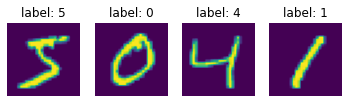

In [17]:
def show_examples(dataset: Dataset, num_examples: int = 4):
    fig, ax = plt.subplots(1, num_examples)
    
    for i in range(num_examples):
        img, label = dataset[i]
        ax[i].imshow(img[0])
        ax[i].set_title(f'label: {label}')
        ax[i].axis('off')
    plt.show()
    
show_examples(dataset=mnist_train)

Посмотрим на несколько примеров из тренировочной выборки

## Задание 1 (бонус)
**(0.4 балла, бонус)** Напишите свою версию датасета, который будет читать картинки с диска.  
Подразумевается, что если вы написали свой датасет, то он будет использоваться при обучении вместо дефолтного `MNIST`.  
Вам понадобится архив [Google Drive](https://drive.google.com/file/d/1DOtScRd7la_sJflLgoNa0vFUuhjlVHa7/view?usp=sharing):
- /
    - /train.csv
    - /val.csv
    - /train/{image_name}.png
    - /val/{image_name}.png

CSV файлы содержат название файла и его лейбл: image_name, label.

*Hint 1:* нужно унаследоваться от класса `Dataset` и переопределить методы `__getitem__` и `__len__`.
Первый должен возвращать картинку и ее лейбл, а второй количество примеров в датасете.
(На самом деле второй метод не обязателен для самого датасета, но он необходим для
[семплера](https://pytorch.org/docs/stable/data.html#torch.utils.data.RandomSampler),
который используется даталоадером)
(см. [PyTorch docs](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset),
[PyTorch tutorual](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html?highlight=dataset))  
*Hint 2:* для работы с картиноками лучше использовать OpenCV: `pip install opencv-python-headless`.
В частности [cv2.imread](https://docs.opencv.org/master/d4/da8/group__imgcodecs.html#ga288b8b3da0892bd651fce07b3bbd3a56).  
*Hint 3:* обратите особое внимание на то, что возвращает функция `cv2.imread`

In [18]:
# https://alexanderkurakin.blogspot.com/2019/01/pytorch-data-loading-preprocessing.html
class DatasetMNIST(Dataset):
    def __init__(self, data, directory):
        self.data = pd.read_csv(data).to_dict('list')
        self.directory = directory

    def __len__(self):
        return len(self.data['image_name'])
    
    def __getitem__(self, index):
        file_name = str(self.data['image_name'][index])
        while len(file_name) < 5:
            file_name = '0' + file_name
        img_name = os.path.join(self.directory, file_name+'.png')
        image = imread(img_name, IMREAD_GRAYSCALE)
        image = (torch.tensor(image, dtype=torch.float64) / 255.0).float()
        label = self.data['label'][index]
        sample = dict(
            sample=image,
            label=label,
        )
        return sample

Проверим как работает созданный нами класс:

In [19]:
train, train_root = 'mnist_data/train.csv', 'mnist_data/train/'
val, val_root = 'mnist_data/val.csv', 'mnist_data/val/'
train_data = DatasetMNIST(train, train_root)
val_data = DatasetMNIST(val, val_root)

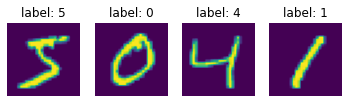

In [20]:
def show_examples(dataset: Dataset, num_examples: int = 4):
    fig, ax = plt.subplots(1, num_examples)
    
    for i in range(num_examples):
        img, label = dataset[i]['sample'], dataset[i]['label']
        ax[i].imshow(img)
        ax[i].set_title(f'label: {label}')
        ax[i].axis('off')
    plt.show()
    
show_examples(dataset=train_data)

In [37]:
train_data[0]['sample'].shape

torch.Size([28, 28])

In [22]:
train_data[0]['sample'].view(-1, 28, 28).shape

torch.Size([1, 28, 28])

## Задание 2
**(0.3 балла)** Напишите класс MLP сети из 3 линейных слоев, которая будет получать на вход
батч картинок размера [BS, C, H, W]

*Hint 1:* метод `reshape` поможет вытянуть картинку в вектор.  
*Hint 2:* выход должен соответствовать количеству лейблов, то есть 10.  
*Hint 3:* пачка линейных слоев подряд не имеет смысла без нелинейностей между ними.

In [9]:
class CustomMLP(nn.Module):
    def __init__(self,
                 num_pixels_per_img: int = 784,  # hint: 28*28 == 784
                 ):
        super().__init__()
        self.num_pixels_per_img = num_pixels_per_img
        self.inner = nn.Sequential(nn.Linear(num_pixels_per_img, 1000), 
                                   nn.ReLU(),
                                   nn.Linear(1000, 500), 
                                   nn.ReLU(), 
                                   nn.Linear(500, 100), 
                                   nn.ReLU(),
                                   nn.Linear(100, 10))

        
    def forward(self, x):
        return self.inner(x)
    
    def compute_all(self, batch):
        x = batch['sample'].view(-1, self.num_pixels_per_img)
        y = batch['label']
        logits = self.inner(x)
        
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics

## Задание 3
**(0.3 балла)** Напишите класс CNN сети из 3 сверточных слоев.

*Hint 1:* на вход все те же батчи размера [BS, C, H, W]  
*Hint 2:* описание сверточных слоев [PyTorch docs](https://pytorch.org/docs/stable/nn.html#convolution-layers)

In [34]:
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.inner = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*3*3, 10)
        )
                                   
    def forward(self, x):
        return self.inner(x)
    
    def compute_all(self, batch):
        x = batch['sample'].view(-1, 1, 28, 28)
        y = batch['label']
        logits = self.forward(x)
        print(x.shape)
        print(y.shape)
        print(logits.shape)
        return
        
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics

In [26]:
train_data[0]['sample'].view(-1, 1, 28, 28).shape

torch.Size([1, 1, 28, 28])

## Задание 4
**(0.3 балла)** Напишите класс CNN сети из 3 блоков с добавлением skip-connection блока
(ResNet [paper](https://arxiv.org/abs/1512.03385)).  
**(0.2 балла, бонус)** Реализовать residual блок в отдельном классе `ResBlock`.

*Hint 1:* на вход все те же батчи размера [BS, C, H, W]  
*Hint 2:* пример skip-connection:  
![image](https://i1.wp.com/dangminhthang.com/wp-content/uploads/2020/06/resnet-block.jpg?fit=400%2C225)

In [28]:
# https://neurohive.io/ru/vidy-nejrosetej/resnet-34-50-101/
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

class ResBlock(nn.Module):
    def __init__(self, input_chanels, hidden_channels, output_channels):
        super(ResBlock, self).__init__()
        self.inner = nn.Sequential(
            nn.Conv2d(input_chanels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channels, output_channels, kernel_size=3, padding=1)
        )
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        identity = x
        x = self.inner(x)+identity
        x = self.relu(x)
        return x
    
    def compute_all(self, batch):
        x = batch['sample']
        y = batch['label']
        logits = self.forward(x)
        
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics


class CustomResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.inner = nn.Sequential(ResBlock(1, 8, 32),
                                   nn.MaxPool2d(2),
                                   ResBlock(32, 16, 32),
                                   nn.MaxPool2d(2),
                                   ResBlock(32, 64, 32),
                                   nn.MaxPool2d(2),
                                   nn.Conv2d(32, 128, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.AdaptiveAvgPool2d((2, 2)),
                                   nn.Flatten(),
                                   nn.Linear(128*2*2, 10))
               
    def forward(self, x):
        return self.inner(x)
    
    def compute_all(self, batch):
        x = batch['sample'].view(-1, 1, 28, 28)
        y = batch['label']
        logits = self.forward(x)
        
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(axis=1) == y).float().mean().cpu().numpy()
        metrics = dict(acc=acc)
        return loss, metrics

## Задание 5
**(0.1 балла)** Инициализируйте и обучите сети из пунктов 1, 2, 3, используя класс `Trainer` из семинара.

In [29]:
class Trainer:
    def __init__(self, model, optimizer, train_dataset, val_dataset, batch_size=128):
        self.model = model
        self.optimizer = optimizer
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset

        self.batch_size = batch_size

        self.device = 'cpu'
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)
        
        self.global_step = 0
        # https://colab.research.google.com/github/tensorflow/tensorboard/blob/master/docs/get_started.ipynb#scrollTo=A4UKgTLb9fKI
        self.writer = SummaryWriter("results/" + datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S"))

    def save_checkpoint(self, path):
        torch.save(self.model.state_dict(), path)

    def train(self, num_epochs):
        model = self.model
        optimizer = self.optimizer
        
        train_loader = DataLoader(self.train_dataset, shuffle=True, pin_memory=True, batch_size=self.batch_size)
        val_loader = DataLoader(self.val_dataset, shuffle=False, pin_memory=True, batch_size=self.batch_size)
        best_loss = float('inf')
        
        for epoch in range(num_epochs):
            model.train()
            for batch in tqdm(train_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                for k, v in details.items():
                    self.writer.add_scalar(k, v, global_step=self.global_step)
                self.global_step += 1
            
            model.eval()
            
            val_losses, accuracies = [], []
            for batch in tqdm(val_loader):
                batch = {k: v.to(self.device) for k, v in batch.items()}
                loss, details = model.compute_all(batch)
                val_losses.append(loss.item())
                accuracies.append(details['acc'])
    
            val_loss = np.mean(val_losses) 
            accuracy = np.mean(accuracies) 
            if val_loss < best_loss:
                self.save_checkpoint("./best_checkpoint.pth")
                best_loss = val_loss
                
            print(val_loss, accuracy)

На моем железе обучение происходит не очень быстро, поэтому ограничимся небольшим количеством эпох и будем надеяться, что этого хватит для приемлемого результата.

In [30]:
model = CustomMLP()
opt = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
trainer = Trainer(model, opt, train_data, val_data, batch_size=64)

In [31]:
trainer.train(10) 

KeyboardInterrupt: 

Результат для MLP
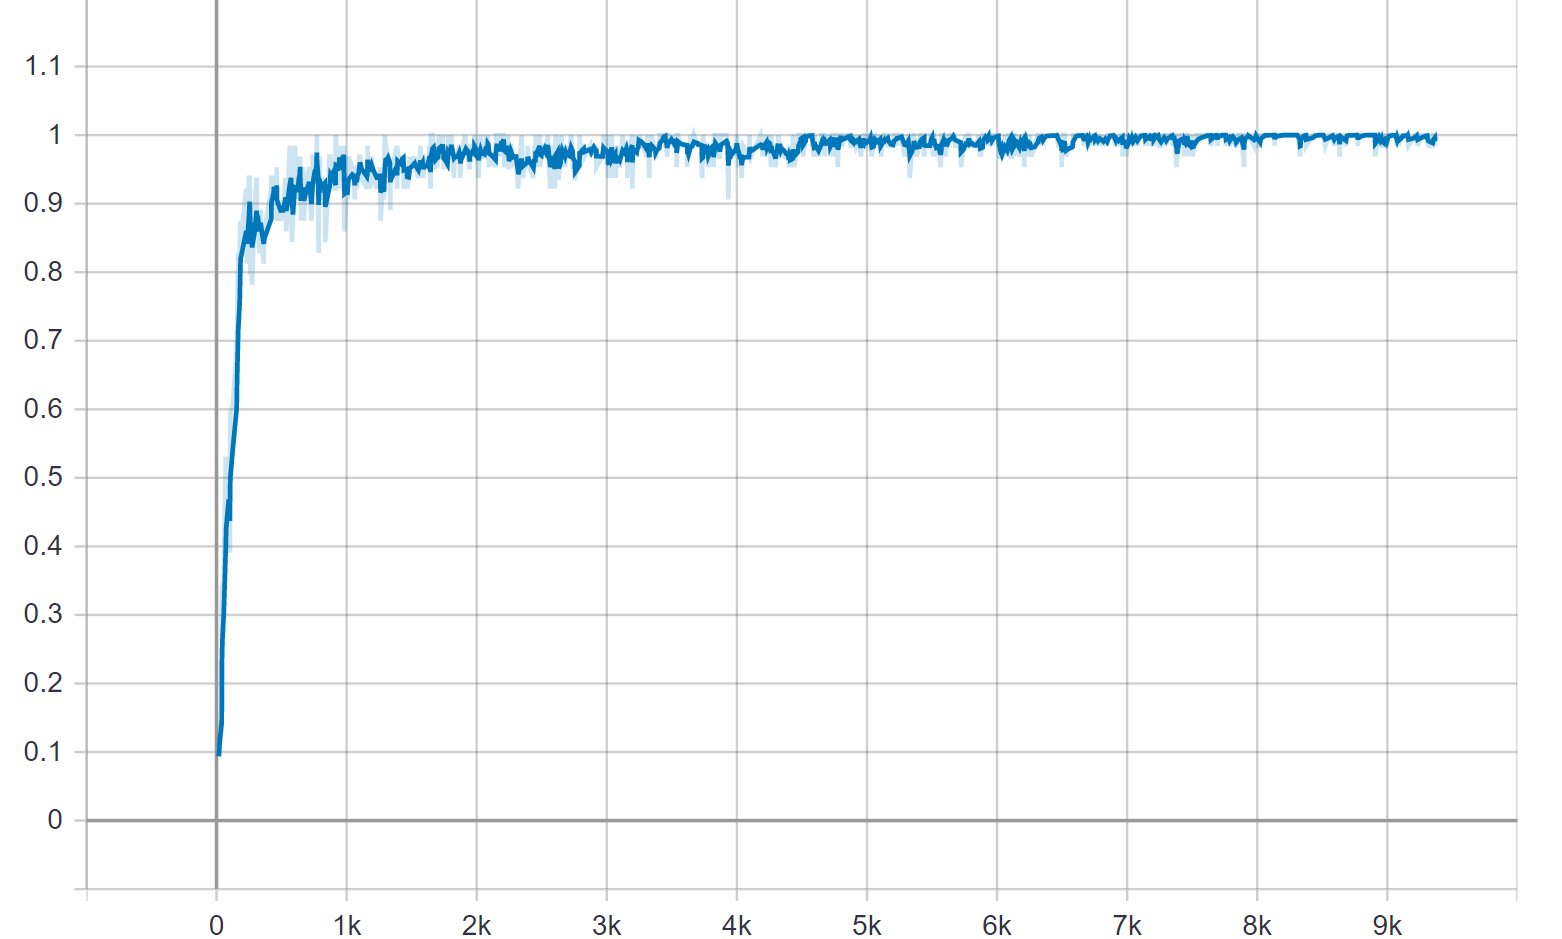

In [35]:
model = CustomCNN()
opt = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
trainer = Trainer(model, opt, train_data, val_data, batch_size=64)

In [36]:
trainer.train(5)

torch.Size([64, 1, 28, 28])
torch.Size([64])
torch.Size([64, 10])



TypeError: cannot unpack non-iterable NoneType object

Результат для CNN
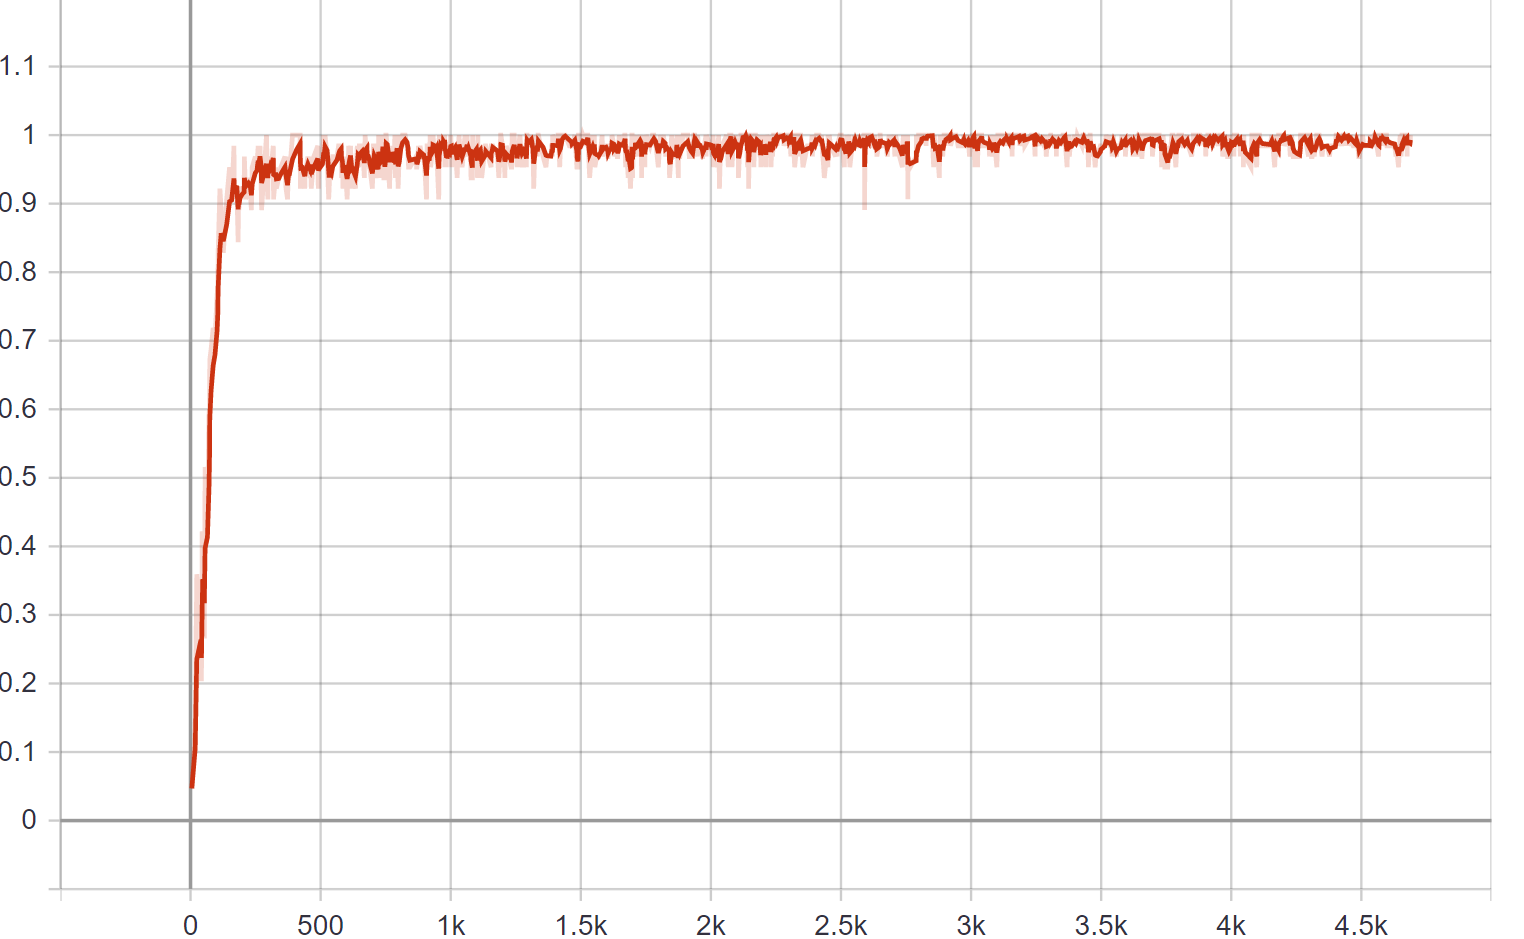

In [16]:
model = CustomResNet()
opt = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
trainer = Trainer(model, opt, train_data, val_data, batch_size=128)

In [17]:
trainer.train(4)


0.09888336103987184 0.96815664



0.05554133332172362 0.9805182



0.04092240729995508 0.986254



0.036215992556933516 0.988034


Результат для ResNet
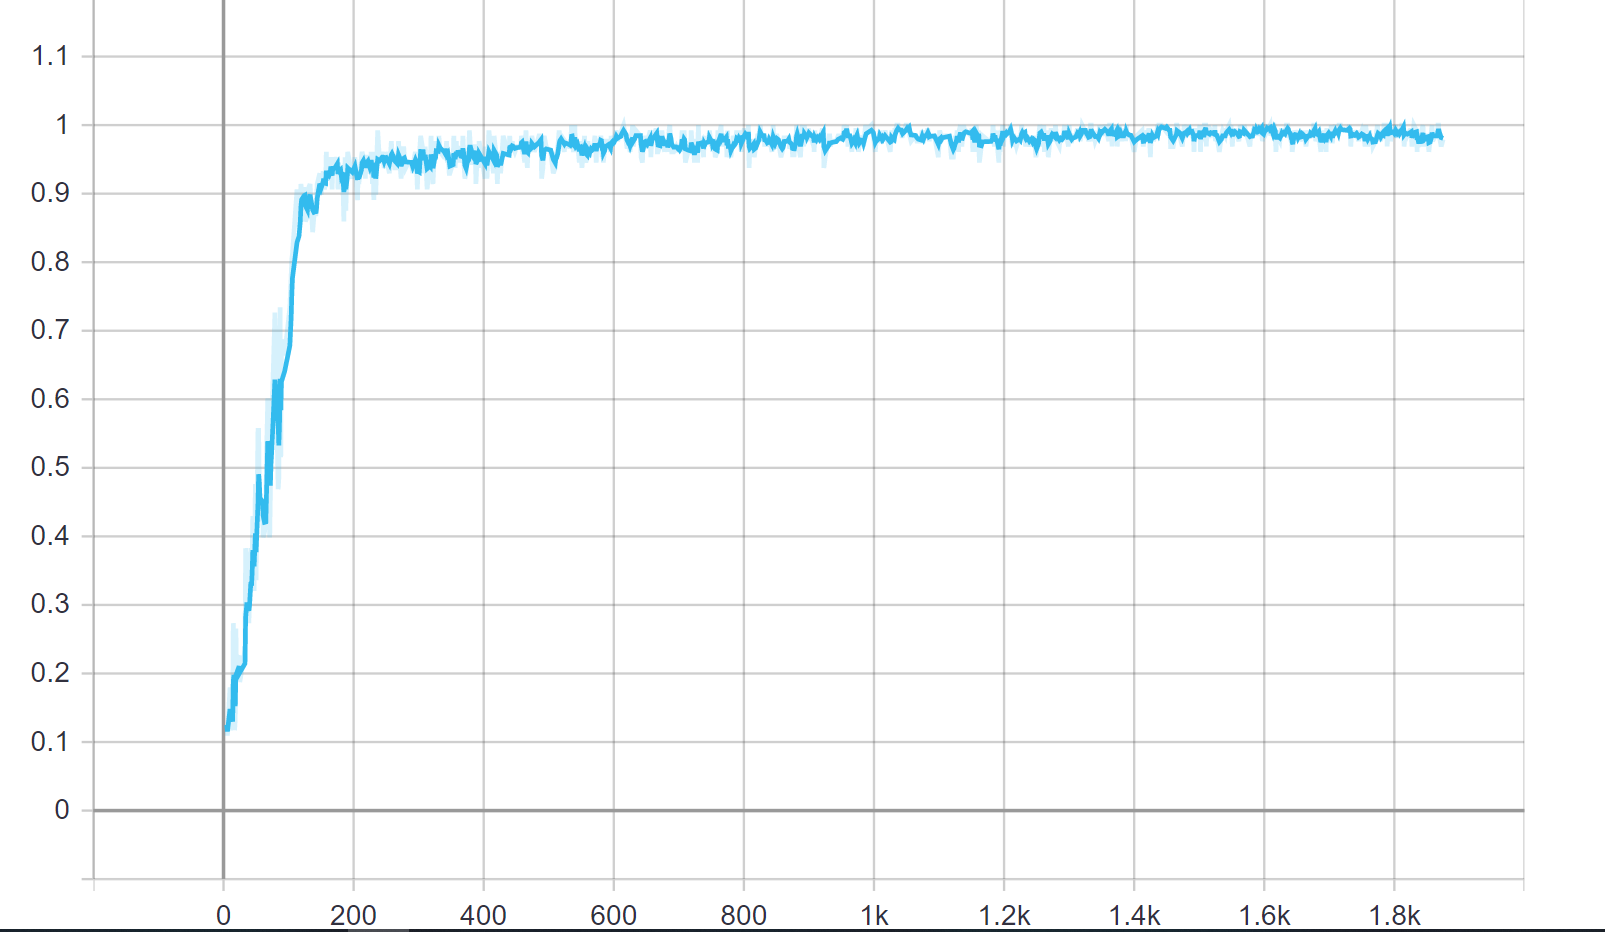

In [18]:
%load_ext tensorboard
# %reload_ext tensorboard

In [21]:
%tensorboard --logdir results

Reusing TensorBoard on port 6006 (pid 9984), started 0:00:32 ago. (Use '!kill 9984' to kill it.)

In [20]:
# to kill tesorboard on Windows https://github.com/tensorflow/tensorboard/issues/2481
# taskkill /im tensorboard.exe /f
# del /q %TMP%\.tensorboard-info\*